In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
from scipy.stats import norm
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
import warnings
warnings.filterwarnings(action="ignore")

# Preprocessing Libraries

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Machine Learning Libraries
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mnist_train.csv')
unseentest=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mnist_test.csv')

Mounted at /content/drive


In [3]:
train.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
#labels have 60K count with mean of exactly 4.5 meaning all training
#data distributed evenly

train['label'].describe()

count    60000.000000
mean         4.500000
std          2.872305
min          0.000000
25%          2.000000
50%          4.500000
75%          7.000000
max          9.000000
Name: label, dtype: float64

# Random Forest Classifier

In [5]:
# Dividing Data and Labels

labels = train['label']
X_drop_labels = train.drop(['label'], axis = 1) #x

# Splitting Train and Test Data

X_train,X_test,y_train,y_test  = train_test_split(X_drop_labels,
                                              labels,
                                              test_size=0.2,
                                              stratify = labels,
                                              random_state = 42)

# Stratified Cross Validation Splitting

sss = StratifiedKFold(n_splits=5)


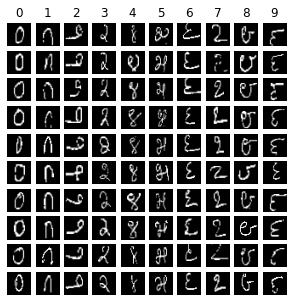

In [6]:
# Visualization Reference Kernel https://www.kaggle.com/josephvm/kannada-with-pytorch
# Some quick data visualization 
# First 10 images of each class in the training set

fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(5,5))

#num_i computed once for each class
for i in range(10): # Column by column
    num_i = X_train[y_train == i]
    ax[0][i].set_title(i)
    for j in range(10): # Row by row
        ax[j][i].axis('off')
        ax[j][i].imshow(num_i.iloc[j, :].to_numpy().\
                        astype(np.uint8).reshape(28, 28), cmap='gray')

In [7]:
start=time.time()
rfc = RandomForestClassifier()

rfc.fit(X_train,y_train)
end=time.time()
print(end-start)

29.77341890335083


In [8]:
prediction_rfc = rfc.predict(X_test)
prediction_rfc

array([5, 4, 5, ..., 8, 2, 8])

In [9]:
#Classification report

print(classification_report(y_test, prediction_rfc))

print(y_test.shape,prediction_rfc.shape)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1200
           1       0.98      1.00      0.99      1200
           2       1.00      0.99      1.00      1200
           3       0.96      0.98      0.97      1200
           4       0.97      0.98      0.98      1200
           5       0.99      0.99      0.99      1200
           6       0.96      0.98      0.97      1200
           7       0.98      0.95      0.97      1200
           8       0.99      0.99      0.99      1200
           9       1.00      0.97      0.98      1200

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000

(12000,) (12000,)


In [10]:
confusion_matrix(y_test, prediction_rfc)

array([[1170,   22,    0,    5,    1,    0,    0,    0,    2,    0],
       [   2, 1195,    0,    1,    2,    0,    0,    0,    0,    0],
       [   4,    1, 1191,    2,    1,    1,    0,    0,    0,    0],
       [   6,    0,    0, 1177,    5,    4,    0,    8,    0,    0],
       [   0,    0,    0,    7, 1182,    7,    0,    0,    2,    2],
       [   0,    0,    0,    5,    9, 1186,    0,    0,    0,    0],
       [   1,    0,    0,    8,    1,    0, 1177,   11,    0,    2],
       [   2,    1,    0,   20,    5,    0,   27, 1145,    0,    0],
       [   5,    4,    0,    1,    1,    1,    0,    0, 1188,    0],
       [   0,    0,    0,    2,    7,    1,   21,    1,    3, 1165]])

In [11]:
#Kaggle submission RFC

unseenXtest = unseentest.drop(columns = 'id')

modeltestrfc = pd.Series(rfc.predict(unseenXtest), name = 'label')
modelsubmissionrfc = pd.concat([unseentest['id'], modeltestrfc], axis=1)

modelsubmissionrfc.to_csv('submission.csv', index = False)

# Random Forest Classifier with PCA

In [12]:
from sklearn import svm
from sklearn.decomposition import PCA

In [13]:
# Dividing Data and Labels

labels = train['label']
X_drop_labels_pca = train.drop(['label'], axis = 1) #x
X_drop_labels_scaled=StandardScaler().fit_transform(X_drop_labels_pca)


#To ensure features between train and unseen test remain same
# X_train = train.drop('label',axis = 1)
X_unseentest = unseentest.drop('id', axis=1)
X_unseentest_scaled=StandardScaler().fit_transform(X_unseentest)

X_combined = pd.concat([X_drop_labels_pca,X_unseentest])

X_combined_scaled = StandardScaler().fit_transform(X_combined)

# Splitting Train and Test Data

X_train,X_test,y_train,y_test  = train_test_split(X_drop_labels_pca,
                                              labels,
                                              test_size=0.2,
                                              stratify = labels,
                                              random_state = 42)


In [14]:
#PCA using 95% variability of explanatory variables

start=time.time()

pca = PCA(0.95)
pca.fit(X_combined_scaled)

end=time.time()
print("seconds: ",end-start)


seconds:  11.363454103469849


In [15]:
# training and unseentest set Standard Scaled
# X_train = train.drop('label', axis=1)


y_train=train['label']

#train and test set fit to the PCA
X_train_pca=pca.fit(X_drop_labels_scaled)
X_unseentest_pca=pca.fit(X_unseentest_scaled)

In [16]:
# #help:

# pca = PCA(0.95)
# X_train_scaled = pca.fit_transform(X_train)
# # classifier use here...
# X_test_scaled = pca.transform(X_test)


In [17]:
start=time.time()

rfc_pca = RandomForestClassifier()
rfc_pca.fit(X_drop_labels_scaled,y_train)

end=time.time()
print(end-start)

print(X_drop_labels_scaled.shape, y_train.shape)

38.433581590652466
(60000, 784) (60000,)


In [18]:
#Predicting y on the validation set (20%)

#y_valpredicdt_rfc_pca = rfc_pca.predict(X_test_scaled)

y_predict_rfc_pca = rfc_pca.predict(X_unseentest_scaled)
y_predict_rfc_pca

array([3, 0, 2, ..., 3, 5, 3])

In [19]:
print(y_test.shape)
print(y_predict_rfc_pca.shape)

(12000,)
(5000,)


In [20]:
#Classification report

#print(classification_report(y_test, y_valpredict_rfc_pca))

In [21]:
#confusion_matrix(y_test, y_predict_rfc_pca)

In [22]:
#Kaggle submission RFC with PCA

# unseenXtest = unseentest.drop(columns = 'id')

modeltestrfc_pca = pd.Series(rfc_pca.predict(unseenXtest), name = 'label')
modelsubmissionrfc = pd.concat([unseentest['id'], modeltestrfc_pca], axis=1)

modelsubmissionrfc.to_csv('submission.csv', index = False)

# K Means Clustering

References:
[1]: https://en.wikipedia.org/wiki/K-means_clustering
[2]: http://yann.lecun.com/exdb/mnist/
[3]: https://en.wikipedia.org/wiki/MNIST_database
[4]: https://www.kaggle.com/ngbolin/mnist-dataset-digit-recognizer

In [23]:
#create the training/test set

X_train = train.drop('label', axis = 1).to_numpy()
y_train = train['label'].to_numpy()

X_test = unseentest.drop('id', axis = 1).to_numpy()

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(5000, 784)


In [24]:
# convert each image to 1 dimensional array

X = X_train.reshape(len(X_train),-1)
Y = y_train

# normalize the data to 0 - 1

X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)


(60000, 784)
(784,)


In [25]:
from sklearn.cluster import MiniBatchKMeans

#The MNIST dataset contains images of the integers 0 to 9. Because of this, let’s start by setting the number of clusters to 10, one for each digit.

n_digits = 10

# Initialize KMeans model

kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
start=time.time()
kmeans.fit(X)
end=time.time()
print("seconds: ",end-start)

kmeans.labels_

seconds:  2.6493237018585205


array([1, 1, 5, ..., 0, 6, 9], dtype=int32)

In [26]:
def infer_cluster_labels(kmeans, actual_labels):
  inferred_labels = {}

  for i in range(kmeans.n_clusters):

    # find index of points in cluster
    labels = []
    index = np.where(kmeans.labels_ == i)

    # append actual labels for each point in cluster
    labels.append(actual_labels[index])

    # determine most common label
    if len(labels[0]) == 1:
        counts = np.bincount(labels[0])
    else:
        counts = np.bincount(np.squeeze(labels))

    # assign the cluster to a value in the inferred_labels dictionary
    if np.argmax(counts) in inferred_labels:
        # append the new number to the existing array at this slot
        inferred_labels[np.argmax(counts)].append(i)
    else:
        # create a new array in this slot
        inferred_labels[np.argmax(counts)] = [i]

    #print(labels)
    #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
    
  return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
  # empty array of len(X)
  predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

  for i, cluster in enumerate(X_labels):
    for key, value in cluster_labels.items():
        if cluster in value:
            predicted_labels[i] = key
            
  return predicted_labels

# test the infer_cluster_labels() and infer_data_labels() functions

cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(Y[:20])

[0 0 2 3 4 5 7 7 8 4 0 5 3 3 4 5 7 7 8 9]
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


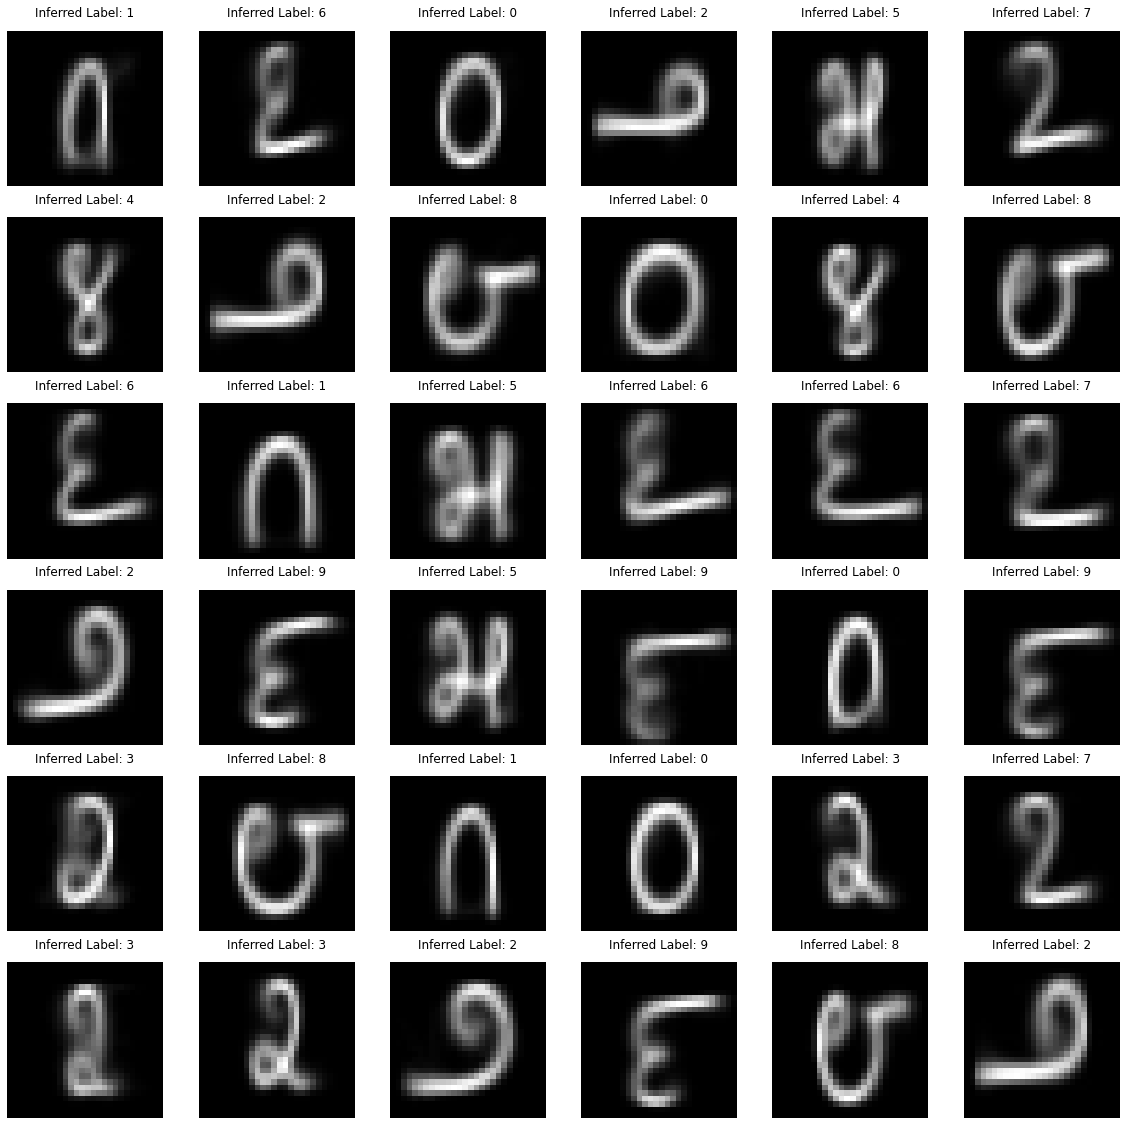

In [27]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()

In [28]:
print('Accuracy: {}\n'.format(accuracy_score(y_train, predicted_labels)))

Accuracy: 0.69075



In [29]:
#running the model on the test set

# convert each image to 1 dimensional array

X_test = X_test.reshape(len(X_test),-1)

# normalize the data to 0 - 1

X_test = X_test.astype(float) / 255.

print(X_test.shape)
print(X_test[0].shape)

(5000, 784)
(784,)


In [30]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 10)
kmeans.fit(X_test)

cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)

In [31]:
kmeans_pred = pd.Series(X_clusters, name = 'label')
kmeans_pred_submission = pd.concat([unseentest['id'], kmeans_pred], axis=1)
kmeans_pred_submission.to_csv('submission.csv', index = False)

# Neural Networks

In [32]:
import tensorflow as tf
from tensorflow import keras

In [34]:
# Dividing Data and Labels
#create the training/test set

X_train = train.drop('label', axis = 1).to_numpy()
y_train = train['label'].to_numpy()

X_unseentest = unseentest.drop('id', axis = 1).to_numpy()

X_train = X_train / 255
X_test = X_test / 255
X_unseentest = X_unseentest / 255

print(X_train.shape)
print(X_test.shape) #Array has already been flattened down to a single array from 28 x 28 to 784
print(X_unseentest.shape)

# Splitting Train and Test Data

X_train,X_test,y_train,y_test  = train_test_split(X_train,
                                              y_train,
                                              test_size=0.2,
                                              stratify = labels,
                                              random_state = 42)

(60000, 784)
(5000, 784)
(5000, 784)


In [35]:
model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(784,), activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3506 - accuracy: 0.9244
Epoch 2/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1488 - accuracy: 0.9610
Epoch 3/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1241 - accuracy: 0.9662
Epoch 4/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1118 - accuracy: 0.9690
Epoch 5/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1042 - accuracy: 0.9702


In [36]:
model.evaluate(X_test, y_test)

375/375 [==============================] - 1s 1ms/step - loss: 0.1056 - accuracy: 0.9678


[0.10564807802438736, 0.9678333401679993]

In [37]:
#predict y on validation test set
y_predicted = model.predict(X_test)
y_predicted[0]

array([1.0310070e-05, 4.2487613e-06, 1.3548136e-04, 3.0291080e-04,
       8.2609642e-01, 9.7799766e-01, 2.5048852e-04, 3.7558621e-05,
       7.3323250e-03, 7.2589517e-04], dtype=float32)

In [38]:
y_test[0]

5

In [39]:
y_predicted[0] #array values of highest probability shows it being the number 5

array([1.0310070e-05, 4.2487613e-06, 1.3548136e-04, 3.0291080e-04,
       8.2609642e-01, 9.7799766e-01, 2.5048852e-04, 3.7558621e-05,
       7.3323250e-03, 7.2589517e-04], dtype=float32)

In [40]:
np.argmax(y_predicted[0]) #return maximum element from array

5

In [41]:
y_predicted_labels=[np.argmax(i) for i in y_predicted]
y_predicted_labels[:5]

[5, 4, 5, 2, 1]

In [42]:
#confusion matrix

cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1156,   30,    0,    8,    1,    0,    1,    0,    4,    0],
       [   5, 1186,    0,    3,    2,    1,    0,    1,    0,    2],
       [   1,    0, 1197,    1,    0,    0,    1,    0,    0,    0],
       [   8,    0,    1, 1159,    2,    8,    4,   17,    1,    0],
       [   2,    0,    0,    7, 1175,    9,    2,    1,    2,    2],
       [   0,    2,    0,   13,   14, 1166,    1,    1,    3,    0],
       [   0,    0,    0,    8,    0,    1, 1128,   63,    0,    0],
       [   3,    2,    0,   34,    1,    1,   44, 1115,    0,    0],
       [   8,    2,    1,    2,    2,    5,    0,    0, 1178,    2],
       [   2,    0,    0,    2,   16,    1,   15,    2,    8, 1154]],
      dtype=int32)>

Note: Rectified Linear Unit is the most commonly used activation function in deep learning models. The function returns 0 if it receives any negative input, but for any positive value  x  it returns that value back. So it can be written as  f(x)=max(0,x) .

Sigmoid function is a mathematical function which has a characteristic S-shaped curve. There are a number of common sigmoid functions, such as the logistic function, the hyperbolic tangent, and the arctangent. In machine learning, the term sigmoid function is normally used to refer specifically to the logistic function, also called the logistic sigmoid function.

All sigmoid functions have the property that they map the entire number line into a small range such as between 0 and 1, or -1 and 1, so one use of a sigmoid function is to convert a real value into one that can be interpreted as a probability.

In [43]:
#adding hidden layer

model = keras.Sequential([
    keras.layers.Dense(100, input_shape=(784,), activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1842 - accuracy: 0.9523
Epoch 2/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0765 - accuracy: 0.9785
Epoch 3/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0508 - accuracy: 0.9847
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0354 - accuracy: 0.9899
Epoch 5/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0259 - accuracy: 0.9926


In [44]:
model.evaluate(X_test,y_test)

375/375 [==============================] - 1s 1ms/step - loss: 0.0555 - accuracy: 0.9844


[0.055535513907670975, 0.984416663646698]

In [45]:
y_predicted = model.predict(X_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1168,   22,    0,    6,    1,    0,    0,    0,    2,    1],
       [   2, 1192,    0,    2,    0,    0,    1,    0,    0,    3],
       [   1,    0, 1195,    3,    0,    1,    0,    0,    0,    0],
       [   3,    0,    0, 1188,    1,    5,    1,    2,    0,    0],
       [   0,    1,    0,    1, 1186,    9,    2,    0,    1,    0],
       [   0,    0,    0,    1,    1, 1196,    0,    1,    1,    0],
       [   0,    0,    0,    3,    0,    0, 1174,   23,    0,    0],
       [   0,    1,    1,   30,    0,    0,   18, 1150,    0,    0],
       [   4,    2,    0,    1,    1,    4,    0,    0, 1187,    1],
       [   1,    1,    0,    0,    5,    0,   13,    1,    2, 1177]],
      dtype=int32)>

In [46]:
#predicting on the unseen test set for Kaggle submission

y_predicted = model.predict(X_unseentest)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
y_predicted_labels_df = pd.DataFrame(data = y_predicted_labels,columns = ['label'])
y_predicted_labels_df.head()

,label
0,3
1,0
2,2
3,6
4,7


In [47]:
#submission to Kaggle
sub = pd.DataFrame(data=unseentest.id)
sub = sub.join(y_predicted_labels_df.label)
# Write out the predictions to disk
sub.to_csv('submission.csv', index=False)

# Convolutional Neural Network


Benan Akca, 2019, Kannada MNIST: CSNN Tutorial with App.
https://www.kaggle.com/benanakca/kannada-mnist-cnn-tutorial-with-app-top-2

In [48]:
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D,LeakyReLU
from tensorflow.keras.optimizers import RMSprop,Nadam,Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

Below we reshape the data since a CNN model must be fit based on 28x28 image instead of the flattened 784 array.

In [49]:
X_train = X_train.reshape(-1, 28, 28,1)
X_test = X_test.reshape(-1, 28, 28,1)
X_unseentest = X_unseentest.reshape(-1,28,28,1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Below we build the model architecture and decide on filter size, padding type, pooling, batch normalization, dropout, and activation function layers.

Batch normalization is a method used to make artificial neural networks faster and more stable through normalization of the layers' inputs by re-centering and re-scaling.

Filter size: "During this learning process of CNN, you find different kernel sizes at different places in the code, then this question arises in one’s mind that whether there is a specific way to choose such dimensions or sizes. The answer is no." (S. Pandey). However author implies 3x3 kernal is most optimal, as also shown in the model below in the 2D convolutional NN.
https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15

Padding: "Padding is a term relevant to convolutional neural networks as it refers to the amount of pixels added to an image when it is being processed by the kernel of a CNN. For example, if the padding in a CNN is set to zero, then every pixel value that is added will be of value zero." (DeepAI.org)
"In order to assist the kernel with processing the image, padding is added to the frame of the image to allow for more space for the kernel to cover the image. Adding padding to an image processed by a CNN allows for more accurate analysis of images." (DeepAI.org).
https://deepai.org/machine-learning-glossary-and-terms/padding

"The term “dropout” refers to dropping out units (hidden and visible) in a neural network." "A new hyperparameter is introduced that specifies the probability at which outputs of the layer are dropped out, or inversely, the probability at which outputs of the layer are retained. The interpretation is an implementation detail that can differ from paper to code library. A common value is a probability of 0.5 for retaining the output of each node in a hidden layer and a value close to 1.0, such as 0.8, for retaining inputs from the visible layer."
https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),    
    
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),##
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.1),
 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [51]:
#RMSprop is a gradient based optimization
optimizer = RMSprop(learning_rate=0.002,###########optimizer = RMSprop(learning_rate=0.0025,###########
    rho=0.9,
    momentum=0.1,
    epsilon=1e-07,
    centered=True,
    name='RMSprop')
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [52]:
# An observation code for our dataset
datagen_try = ImageDataGenerator(rotation_range=15,
                             width_shift_range = 0.15,
                             height_shift_range = 0.15,
                             shear_range = 0.15,
                             zoom_range = 0.4,)
# fit parameters from data
datagen_try.fit(X_train)
# configure batch size and retrieve one batch of images


In [53]:
batch_size = 1024
num_classes = 10
epochs = 2

datagen_train = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.1,
                                   zoom_range = 0.4,
                                   horizontal_flip = False)

datagen_val = ImageDataGenerator() 


step_train = X_train.shape[0] // batch_size
step_val = X_test.shape[0] // batch_size

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau( 
    monitor='loss',    # Quantity to be monitored.
    factor=0.25,       # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=2,        # The number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,         # 0: quiet - 1: update messages.
    mode="auto",       # {auto, min, max}. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; 
                       # in the max mode it will be reduced when the quantity monitored has stopped increasing; 
                       # in auto mode, the direction is automatically inferred from the name of the monitored quantity.
    min_delta=0.0001,  # threshold for measuring the new optimum, to only focus on significant changes.
    cooldown=0,        # number of epochs to wait before resuming normal operation after learning rate (lr) has been reduced.
    min_lr=0.00001     # lower bound on the learning rate.
    )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

In [54]:
#model fit
history = model.fit_generator(datagen_train.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train)//batch_size,
                              epochs=epochs,
                              validation_data=(X_test, y_test),
                              validation_steps=40,
                              callbacks=[learning_rate_reduction, es],
                              verbose=2)

Epoch 1/2
46/46 - 1212s - loss: 1.4207 - accuracy: 0.5085 - val_loss: 2.3324 - val_accuracy: 0.1359
Epoch 2/2
46/46 - 1211s - loss: 0.3805 - accuracy: 0.8723 - val_loss: 1.1823 - val_accuracy: 0.7746


In [55]:
model.evaluate(X_test, y_test, verbose=2);

375/375 - 71s - loss: 1.1823 - accuracy: 0.7746


In [56]:
y_predicted = model.predict(X_test)
y_grand_truth = y_test
y_predicted = np.argmax(y_predicted,axis=1)
y_grand_truth = np.argmax(y_grand_truth,axis=1)
cm = confusion_matrix(y_grand_truth, y_predicted)
cm

array([[1183,    0,    0,   16,    0,    1,    0,    0,    0,    0],
       [1063,   38,    0,   88,    0,   11,    0,    0,    0,    0],
       [   6,    0, 1176,   17,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0, 1199,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0,  266,  662,  272,    0,    0,    0,    0],
       [   0,    0,    0,    8,    0, 1192,    0,    0,    0,    0],
       [   2,    0,    0,   22,   14,    0, 1022,  138,    1,    1],
       [   7,    0,    0,  151,    0,    0,    2, 1040,    0,    0],
       [  16,    0,    1,    3,   24,   13,    0,    0, 1143,    0],
       [   2,    0,    0,    5,  541,    0,    6,    0,    6,  640]])

In [57]:
#predicting on the unseen test set for Kaggle submission
y_predicted = model.predict(X_unseentest)
y_predicted = np.argmax(y_predicted,axis=1)


In [58]:
y_predicted_df = pd.DataFrame(data = y_predicted,columns = ['label'])
y_predicted_labels_df.head()

,label
0,3
1,0
2,2
3,6
4,7


In [59]:

#submission to Kaggle
sub = pd.DataFrame(data=unseentest.id)
sub = sub.join(y_predicted_df.label)
# Write out the predictions to disk
sub.to_csv('submission.csv', index=False)